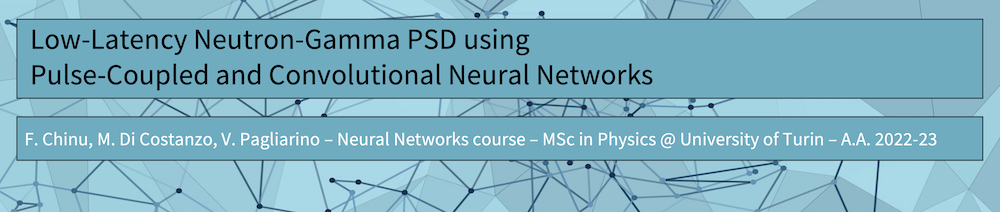

# 'Student' model based on CNN 1D

In [2]:
# Use Python 3.8.10 on UNITO HPC4AI MLJC computing node - Tensorflow supporting GPU with libcudart.so.10.1
import numpy as np
np.random.seed(19)

import random
random.seed(10)

import scipy as sp
#from scipy.misc import imresize
from scipy.io import loadmat
#from scipy.fft import *
#from scipy.signal import convolve2d

import pandas as pd
import pickle

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR) #Disable TF Warnings
import tensorflow as tf

import tensorflow as tf
from tensorflow.keras import regularizers

import keras
import keras_tuner
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.utils.vis_utils import plot_model

import visualkeras
import pydot
import graphviz
from PIL import ImageFont

import sklearn as sk
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from matplotlib import pyplot as plt
import seaborn as sb
import plotly.express as px

if tf.config.list_physical_devices('GPU'):
    print('GPU is available! (', tf.config.list_physical_devices(), ")")
else:
    print('GPU not properly loaded! Training is going to run on CPU')

GPU is available! ( [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] )


### Importing Dataset 3: Training + Validation Dataset

In [3]:
with open('./arrays/dataset3_PCNN_Out_loose.p', 'rb') as handle:
    trainingSetDict = pickle.load(handle)

trainSetGamma = trainingSetDict['raw_gamma']
trainSetNeutron = trainingSetDict['raw_neutron']

trainSetGamma = trainSetGamma[0:min(len(trainSetGamma),len(trainSetNeutron))]
trainSetNeutron = trainSetNeutron[0:min(len(trainSetGamma),len(trainSetNeutron))]

### ENCODING! 0 = Gamma, 1 = Neutron
trainingSetValues = np.vstack((trainSetGamma, trainSetNeutron))
trainingSetLabels = np.array([0,] * len(trainSetGamma) + [1,] * len(trainSetNeutron))

### Data augmentation with negative polarity pulses
trainingSetValues = np.vstack((trainingSetValues,trainingSetValues*-1.0))
trainingSetLabels = np.tile(trainingSetLabels, (1,2)).transpose()


### Require traslational invariance
for i in range(len(trainingSetValues)):
    ### WARNING!!! DISABLE THIS FOR SPATIAL ATTENTION ANALYSIS ACROSS MINIBATCHES!
    shift = random.randint(-60, 180)
    trainingSetValues[i] = np.roll(trainingSetValues[i], shift)

trainingSetValues, trainingSetLabels = shuffle(trainingSetValues, trainingSetLabels, random_state=4)

### TrainValid / Test separation
trainValidValues, testSetValues, trainValidLabels, testSetLabels = train_test_split(trainingSetValues, trainingSetLabels, test_size=0.1, random_state=1900234578)

test_set = {'testVal' : testSetValues, 'testLab' : testSetLabels}

with open('./model/testSetp.p', 'wb') as handle:
    pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL);

### Training / Validation separation
X_train, X_val, y_train, y_val = train_test_split(trainValidValues, trainValidLabels, test_size=0.4, random_state=1989234578)
dt3 = X_train
dt3l = y_train

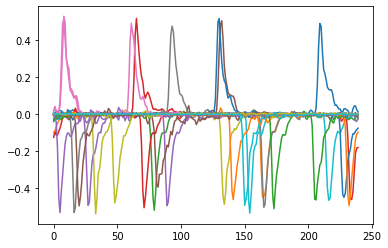

In [4]:
for i in range(30):
    plt.plot(trainingSetValues[i])

In [5]:
timeSamples = X_train.shape[1]
print("Training test size: ", X_train.shape, "  labels: ", y_train.shape)
print("Validation test size: ", X_val.shape, "  labels: ", y_val.shape)
print("Time samples: ", timeSamples)

Training test size:  (111894, 240)   labels:  (111894, 1)
Validation test size:  (74596, 240)   labels:  (74596, 1)
Time samples:  240


In [6]:
#fig, ax = plt.subplots(figsize=(12, 7))
#for i in range(100):
#    ax.plot(X_train[y_train==0][i], color="blue");
#for i in range(100):
#    ax.plot(X_train[y_train==1][i], color="red");

### Model definition

In [7]:
input_shape = (timeSamples, 1)  

def build_model(hp):
    # CNN 1D
    modelHp = Sequential()
    filtersnum1 = hp.Int("filtersnum1", 4,13, step = 3, sampling = "linear")
    ksize = hp.Int("kernelsize", 6,18, step = 4, sampling = "linear")
    
    modelHp.add(Conv1D(filtersnum1, 
                kernel_size=ksize, 
                activation='relu', input_shape=input_shape))
    
    modelHp.add(MaxPooling1D(pool_size=2))
    
    modelHp.add(Conv1D(filtersnum1 * 2, 
                kernel_size=ksize, 
                activation='relu'))
    
    modelHp.add(MaxPooling1D(pool_size=2))
    
    modelHp.add(Flatten())
        
    l1regularization = l1=hp.Float("dense1L1reg", 5e-5,1e-2, step = 50, sampling = "log")
    modelHp.add(Dense(hp.Int("densenum1", 16, 70, step = 18, sampling = "linear"),
                       activation='relu', 
                       kernel_regularizer=regularizers.L1L2(l1=l1regularization, 
                                                            l2=0.0)))
    
    modelHp.add(Dense(1, activation='sigmoid'))
    
    # Minimizer
    optim = keras.optimizers.Adam(learning_rate = hp.Float("learning_rate", 1e-6,1e-2, step = 10, sampling = "log"))

    # Compile
    modelHp.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Print summary
    modelHp.summary()
    return modelHp

### Import trained model with best hyperparameters

In [30]:
def load_trained_best_model():
    final_hp_choice = keras_tuner.HyperParameters()

    final_hp_choice.Fixed('filtersnum1'  , value = 4)
    final_hp_choice.Fixed('kernelsize'   , value = 6)
    final_hp_choice.Fixed('dense1L1reg'  , value = 5e-5)
    final_hp_choice.Fixed('densenum1'    , value = 34)
    final_hp_choice.Fixed('learning_rate', value = 0.001)

    model = build_model(final_hp_choice)
    model.load_weights('./model/fullTraining.h5')
    return model

In [31]:
def load_untrained_best_model():
    final_hp_choice = keras_tuner.HyperParameters()

    final_hp_choice.Fixed('filtersnum1'  , value = 4)
    final_hp_choice.Fixed('kernelsize'   , value = 6)
    final_hp_choice.Fixed('dense1L1reg'  , value = 5e-5)
    final_hp_choice.Fixed('densenum1'    , value = 34)
    final_hp_choice.Fixed('learning_rate', value = 0.001)

    model = build_model(final_hp_choice)
    model.load_weights('./model/empty_weights.h5')
    return model

### Early stopping callback

In [32]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

### Hyperparameters optimization

In [ ]:
tf.autograph.set_verbosity(0)
Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization" by Lisha Li et al. in 2018
tuner = keras_tuner.Hyperband( 
    build_model,
    project_name = 'CNN_HP_Optim',
    objective = 'val_loss',
    max_epochs = 5,
    overwrite = True)
   
tuner.search(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[stop_early], workers=8, batch_size=20, use_multiprocessing = True)

# Choose the best model
modelList = tuner.get_best_models()
model = modelList[0]

In [ ]:
tuner.results_summary(num_trials=10)

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
final_hp_choice = keras_tuner.HyperParameters()

final_hp_choice.Fixed('filtersnum1'  , value = 4)
final_hp_choice.Fixed('kernelsize'   , value = 6)
final_hp_choice.Fixed('dense1L1reg'  , value = 5e-5)
final_hp_choice.Fixed('densenum1'    , value = 34)
final_hp_choice.Fixed('learning_rate', value = 0.001)

model = build_model(final_hp_choice)

### Save model with optimized hyperparameters

In [ ]:
model_dict_hp = {'hyperparam_optimized_model': model};

with open('./model/hyperParamOpt.p', 'wb') as handle:
    pickle.dump(model_dict_hp, handle, protocol=pickle.HIGHEST_PROTOCOL);
    
model.save('./model/hpOptim');
model.save_weights('./model/empty_weights.h5')

### Model visualization

In [ ]:
visualkeras.layered_view(model, legend=True, draw_volume=True, to_file='modelArcDraw.png')

In [ ]:
visualkeras.layered_view(model, legend=True, draw_volume=False)

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Model Training

In [ ]:
# Convert numpy arrays to TensorFlow tensors
#X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
#y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
#X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
#y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
tf.autograph.set_verbosity(0, False)
model = load_untrained_best_model()
from keras import backend as K
K.set_value(model.optimizer.learning_rate, 0.001)

# Start the training process
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=20, callbacks=[stop_early])
model.save_weights('./model/fullTraining.h5')

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 235, 4)            28        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 117, 4)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 112, 8)            200       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 56, 8)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 448)               0         
                                                                 
 dense_2 (Dense)             (None, 34)               

### Save model post training

In [ ]:
model_dict_t = {'trained_model': model, 'history' : history};

with open('./model/trained.p', 'wb') as handle:
    pickle.dump(model_dict_t, handle, protocol=pickle.HIGHEST_PROTOCOL);
    
model.save('./model/trained');

### Training with K-Fold cross validation

In [9]:
len(X_train) / 12

9324.5

In [17]:
batch_size = 20
no_epochs = 7
number_of_folds = 12
verbosity = 1
model = load_untrained_best_model()
acc_per_fold = []
loss_per_fold = []
histories = []
fold_no = 1 #Iterator

kfold = KFold(n_splits=number_of_folds, shuffle=True)
for train, test in kfold.split(X_train, y_train):
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  model.load_weights('./model/empty_weights.h5')
  history = model.fit(X_train[train], y_train[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=[stop_early])
  model.save_weights("./model/kfold_{}.h5".format(str(fold_no)))

  histories.append(history)

  # Generate generalization metrics
  scores = model.evaluate(X_train[test], y_train[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')


#### Average scores for all folds:
Accuracy: 99.98212506373723 $\pm$ 0.024508964804480247
<br>
Loss: 0.0050909983304639654

In [ ]:
model_metrics_t = {'acc_per_fold': acc_per_fold, 'loss_per_fold' : loss_per_fold, 'histories' : histories}

with open('./model/trained_model_metrics.p', 'wb') as handle:
    pickle.dump(model_metrics_t, handle, protocol=pickle.HIGHEST_PROTOCOL);

In [ ]:
with open('./model/trained_model_metrics.p', 'rb') as handle:
    model_metrics_t = pickle.load(handle)
histories = model_metrics_t['histories']

### Model evaluation on the test set

In [ ]:
score, acc = model.evaluate(testSetValues.transpose()[0:240].transpose(), testSetLabels)
print('Test score:', score)
print('Test accuracy:', acc)

### ROC curve: on training set

In [ ]:
model.load_weights('./model/fullTraining.h5')
y_predicted = model.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_predicted, pos_label=1)

In [ ]:
plt.plot(fpr, tpr)
plt.ylim(0.95, 1.01)
plt.xlim(-0.01, 0.05)

### ROC AUC Score: training set

In [ ]:
roc_auc_score(y_train, y_predicted)

### ROC curve: on test set

In [ ]:
model.load_weights('./model/fullTraining.h5')
y_predicted = model.predict(testSetValues.transpose()[0:240].transpose())
fpr, tpr, thresholds = roc_curve(testSetLabels, y_predicted, pos_label=1)

In [ ]:
plt.plot(fpr, tpr)
plt.ylim(0.995, 1.01)
plt.xlim(-0.01, 0.05)

### ROC AUC Score: test set

In [ ]:
roc_auc_score(testSetLabels, y_predicted)

### Saliency Map / occlusion test (CNN attention evaluation) on test set

In [ ]:
occlusedDatasets = []
stride = 1
window = 10
for i in range(int(len(testSetData.transpose()) / stride)):
    if (i*stride + window < len(testSetData.transpose())):
        occlusedDataset_i = np.copy(testSetData)
        occlusedDataset_i[:,i*stride:(i*stride+window)] *= 0.0
        occlusedDatasets.append(occlusedDataset_i)
        if ( i == 0): np.savetxt("occlTest.csv", occlusedDataset_i, delimiter=",")

In [ ]:
y_scores = []
y_acc = []

for ds in occlusedDatasets:
    score, acc = model.evaluate(ds, testSetLabels, use_multiprocessing=True, workers = 16)
    y_scores.append(score)
    y_acc.append(acc)

In [ ]:
saliency_dict = {'y_scores' : y_scores, 'y_acc' : y_acc}

with open('./model/saliency_map.p', 'wb') as handle:
    pickle.dump(saliency_dict, handle, protocol=pickle.HIGHEST_PROTOCOL);

In [ ]:
for i in range(1):
    plt.plot(occlusedDatasets[0][0])
plt.plot(np.linspace(0, 240, len(y_acc)), 1-np.array(y_acc))

### t-SNE

In [ ]:
featureExtractionModel = tf.keras.Model(inputs=model.input, outputs=model.layers[-3].output)
extractedFeatures = featureExtractionModel.predict(trainingSetValues_.transpose()[0:240].transpose()[0:10000])
tsne = TSNE(n_components=3, verbose=1, perplexity=50).fit_transform(extractedFeatures)

In [ ]:
tsne_dict = {'tsne' : tsne, 'labels' : trainingSetLabels_[:,0][0:10000]}

with open('./model/tsne.p', 'wb') as handle:
    pickle.dump(tsne_dict, handle, protocol=pickle.HIGHEST_PROTOCOL);

In [ ]:
fig, ax = plt.subplots()
ax.scatter(tsne[:,0][trainingSetLabels_[:,0][0:10000] == 0], tsne[:,1][trainingSetLabels_[:,0][0:10000] == 0], color = 'red', alpha = 0.2)
ax.scatter(tsne[:,0][trainingSetLabels_[:,0][0:10000] == 1], tsne[:,1][trainingSetLabels_[:,0][0:10000] == 1], color = 'blue', alpha = 0.2)

In [ ]:
trainingSetLabels_.shape

## Transfer learning to Dataset 1

In [11]:
with open('./arrays/testset.p', 'rb') as handle:
    dataset_dict = pickle.load(handle)
    
dataset1SetGamma = dataset_dict['gammaDataset']
dataset1SetNeutron = dataset_dict['neutronDataset']

dataset1SetGamma = dataset1SetGamma[0:min(len(dataset1SetGamma),len(dataset1SetNeutron))]
dataset1SetNeutron = dataset1SetNeutron[0:min(len(dataset1SetGamma),len(dataset1SetNeutron))]

## ENCODING! 0 = Gamma, 1 = Neutron
dataset1SetValues = np.vstack((dataset1SetGamma, dataset1SetNeutron)).transpose()[0:240].transpose()
dataset1SetLabels = np.array([0,] * len(dataset1SetGamma) + [1,] * len(dataset1SetNeutron))

X_tv, X_test, y_tv, y_test = train_test_split(dataset1SetValues, dataset1SetLabels, test_size=0.3, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.4, random_state=1989234578)

In [ ]:
model = load_trained_best_model()
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
transferredModel = keras.models.clone_model(model)

#### Freezing layers and fine tuning the first Conv1D

In [ ]:
for i in range(len(transferredModel.layers)):
    if (i > 2): transferredModel.layers[i].trainable = False
    else: transferredModel.layers[i].trainable = True
    
transferredModel.build((None, 240))
transferOptim = keras.optimizers.Adam(learning_rate = 0.0008) # Lower learning rate!
transferredModel.compile(optimizer=transferOptim, loss='binary_crossentropy', metrics=['accuracy'])
transferredModel.summary()

In [ ]:
transfHistory = transferredModel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=20, callbacks=[stop_early])

In [ ]:
y_train_predicted = transferredModel.predict(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_train_predicted, pos_label=1)

y_test_predicted = transferredModel.predict(X_test)
Testfpr, Testtpr, thresholds = roc_curve(y_test, y_test_predicted, pos_label=1)

metrics = {'hist': transfHistory, 'Trainfpr': fpr, 'Traintpr': tpr, 'Testfpr': Testfpr, 'Testtpr': Testtpr}

with open('./model/Transf_metrics_ds1.p', 'wb') as handle:
    pickle.dump(metrics, handle, protocol=pickle.HIGHEST_PROTOCOL);

In [ ]:
print(roc_auc_score(y_train, y_train_predicted))
print(roc_auc_score(y_test, y_test_predicted))

In [ ]:
featureExtractionTransferredModel = tf.keras.Model(inputs=transferredModel.input, outputs=transferredModel.layers[-3].output)
extractedFeaturesTransferred = featureExtractionTransferredModel.predict(X_test)
tsne = TSNE(n_components=2, verbose=1, perplexity=15).fit_transform(extractedFeaturesTransferred)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(tsne[:,0][y_test == 0], tsne[:,1][y_test == 0], color = 'red', alpha = 0.2)
ax.scatter(tsne[:,0][y_test == 1], tsne[:,1][y_test == 1], color = 'blue', alpha = 0.2)

### Transfer learning to Dataset 2

In [ ]:
model = load_trained_best_model()

In [ ]:
with open('./arrays/Dataset2_Classified_PCNN.p', 'rb') as handle:
    dataset_dict = pickle.load(handle)
    
dataset2SetGamma = dataset_dict['gammaDataset']
dataset2SetNeutron = dataset_dict['neutronDataset']

dataset2SetGamma = dataset2SetGamma[0:min(len(dataset2SetGamma),len(dataset2SetNeutron))]
dataset2SetNeutron = dataset2SetNeutron[0:min(len(dataset2SetGamma),len(dataset2SetNeutron))]

## ENCODING! 0 = Gamma, 1 = Neutron
dataset2SetValues = np.vstack((dataset2SetGamma, dataset2SetNeutron)).transpose()[0:240].transpose()
dataset2SetLabels = np.array([0,] * len(dataset2SetGamma) + [1,] * len(dataset2SetNeutron))

X_tv, X_test, y_tv, y_test = train_test_split(dataset2SetValues, dataset2SetLabels, test_size=0.3, random_state=19)
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=0.4, random_state=1989234578)

In [ ]:
score, acc = model.evaluate(X_test, y_test)
print('Test score:', score)
print('Test accuracy:', acc)

In [ ]:
transferredModel = keras.models.clone_model(model)

#### Freezing layers and fine tuning the first Conv1D

In [ ]:
for i in range(len(transferredModel.layers)):
    if (i > 2): transferredModel.layers[i].trainable = False
    else: transferredModel.layers[i].trainable = True
    
transferredModel.build((None, 240))
transferOptim = keras.optimizers.Adam(learning_rate = 0.0008) # Lower learning rate!
transferredModel.compile(optimizer=transferOptim, loss='binary_crossentropy', metrics=['accuracy'])
transferredModel.summary()

In [ ]:
transfHistory = transferredModel.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=20, callbacks=[stop_early])

In [ ]:
featureExtractionTransferredModel = tf.keras.Model(inputs=transferredModel.input, outputs=transferredModel.layers[-3].output)
extractedFeaturesTransferred = featureExtractionTransferredModel.predict(X_test)
tsne = TSNE(n_components=2, verbose=1, perplexity=15).fit_transform(extractedFeaturesTransferred)

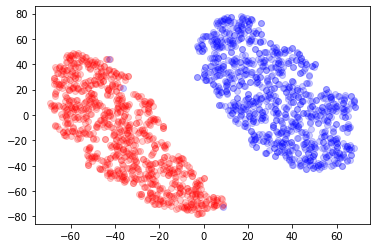

In [ ]:
fig, ax = plt.subplots()
ax.scatter(tsne[:,0][y_test == 0], tsne[:,1][y_test == 0], color = 'red', alpha = 0.2)
ax.scatter(tsne[:,0][y_test == 1], tsne[:,1][y_test == 1], color = 'blue', alpha = 0.2)